In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
path = "./../data/movielens-100k/"

In [3]:
#!wget -P $path https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/movielens-100k/data
#!wget -P $path https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/movielens-100k/item

In [4]:
!ls $path

data  genre  info  item  occupation  README  user


In [5]:
df = pd.read_csv(path+"data", delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
df.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movies_df = pd.read_csv(path+"item",  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies_df.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
df.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [8]:
num_users  = df["user"].nunique()
num_movies = df["movie"].nunique()

print("Number of ratings:", len(df))
print("Number of users:  ", num_users)
print("Number of movies: ", num_movies)

Number of ratings: 100000
Number of users:   943
Number of movies:  1682


# Prepare data

In [9]:
df["user"]  = df["user"]  - 1 # Para empezar en 0
df["movie"] = df["movie"] - 1 # Para empezar en 0
df["rating"]  = df["rating"].values.astype(np.float32)


movies_df["movie"] = movies_df["movie"] - 1 # Para empezar en 0


# Normalize the targets between 0 and 1. Makes it easy to train.
min_rating = min(df["rating"])
max_rating = max(df["rating"])
df["rating_norm"] = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

# Split train (90%), val (10%)

In [10]:
df = df.sample(frac=1, random_state=42) # Shuffle
x  = df[["user", "movie"]].values
y  = df["rating"].values
y2 = df["rating_norm"].values

train_indices = int(0.9 * df.shape[0]) # Assuming training on 90% of the data and validating on 10%.
x_train = x[:train_indices]
x_val   = x[train_indices:]
y_train = y[:train_indices]
y_val   = y[train_indices:]
y2_train = y2[:train_indices]
y2_val   = y2[train_indices:]

# Create Model

In [11]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, classification=False, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users      = num_users
        self.num_movies     = num_movies
        self.embedding_size = embedding_size
        self.classification = classification

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        if self.classification:
            # The sigmoid activation forces the rating to between 0 and 1
            x = tf.nn.sigmoid(x)
        return x

# Train model (as binary classifier)

In [12]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE, classification=True)
model.compile(
    loss      = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.001)
)

history = model.fit(
    x=x_train,
    y=y2_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y2_val),
)

Epoch 1/5
1407/1407 [==============================] - 1s 994us/step - loss: 0.6517 - val_loss: 0.6375
Epoch 2/5
1407/1407 [==============================] - 1s 930us/step - loss: 0.6272 - val_loss: 0.6290
Epoch 3/5
1407/1407 [==============================] - 1s 900us/step - loss: 0.6195 - val_loss: 0.6229
Epoch 4/5
1407/1407 [==============================] - 1s 904us/step - loss: 0.6164 - val_loss: 0.6211
Epoch 5/5
1407/1407 [==============================] - 1s 904us/step - loss: 0.6169 - val_loss: 0.6194


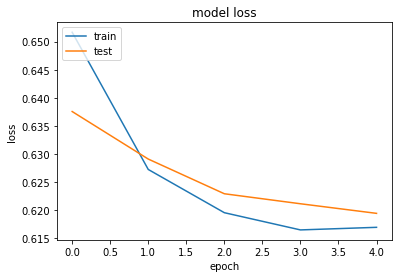

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
model.predict(x_val)

array([[0.36488193],
       [0.7390823 ],
       [0.40686136],
       ...,
       [0.62186265],
       [0.4172713 ],
       [0.51090074]], dtype=float32)

# Train model (as regressor)

In [15]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE, classification=False)
model.compile(
    loss      = tf.keras.losses.MeanSquaredError(), # "mse"
    optimizer = keras.optimizers.Adam(lr=0.001)
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 1s 927us/step - loss: 4.7864 - val_loss: 1.2327
Epoch 2/5
1407/1407 [==============================] - 1s 892us/step - loss: 1.1337 - val_loss: 1.2002
Epoch 3/5
1407/1407 [==============================] - 1s 880us/step - loss: 1.0322 - val_loss: 1.1451
Epoch 4/5
1407/1407 [==============================] - 1s 895us/step - loss: 0.9980 - val_loss: 1.0825
Epoch 5/5
1407/1407 [==============================] - 1s 905us/step - loss: 0.9996 - val_loss: 1.0846


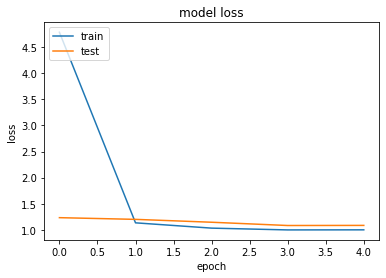

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Prededir validación

In [17]:
model.predict(x_val)

array([[1.0237403],
       [2.392202 ],
       [1.2099521],
       ...,
       [1.2229949],
       [0.4144891],
       [0.7465278]], dtype=float32)

# Predecir test: Recomendaciones de peliculas no vistas para un usuario

### Pelis vistas del usuario

In [18]:
user = 0
movies_watched_by_user = df[df.user == user][["movie", "rating"]]
movies_watched_by_user = movies_watched_by_user.merge(movies_df).sort_values(by=['rating'], ascending=False)
movies_watched_by_user

,movie,rating,title
88,164,5.0,Jean de Florette (1986)
86,168,5.0,"Wrong Trousers, The (1993)"
112,47,5.0,Hoop Dreams (1994)
110,49,5.0,Star Wars (1977)
108,227,5.0,Star Trek: The Wrath of Khan (1982)
...,...,...,...
94,230,1.0,Batman Returns (1992)
62,253,1.0,Batman & Robin (1997)
93,265,1.0,Kull the Conqueror (1997)
82,259,1.0,Event Horizon (1997)


### Generar predicciones de las no vistas

In [19]:
movies_not_watched = movies_df[ ~movies_df["movie"].isin(movies_watched_by_user.movie.values) ].copy()

In [20]:
user_new_movies = np.vstack(
    ([user] * len(movies_not_watched), movies_not_watched.movie)
).T
user_new_movies

array([[   0,  272],
       [   0,  273],
       [   0,  274],
       ...,
       [   0, 1679],
       [   0, 1680],
       [   0, 1681]])

In [21]:
ratings = model.predict(user_new_movies).flatten()
ratings

array([ 1.0451986 ,  0.969295  ,  1.4042884 , ..., -0.0062649 ,
        0.1392503 ,  0.07258292], dtype=float32)

### Recomendar las con mayor puntuacion de predicción

In [22]:
movies_not_watched["Pred rating"] = ratings
movies_not_watched.sort_values(by=['Pred rating'], ascending=False, ignore_index=True)

,movie,title,Pred rating
0,482,Casablanca (1942),1.935495
1,602,Rear Window (1954),1.893157
2,317,Schindler's List (1993),1.813106
3,479,North by Northwest (1959),1.724462
4,473,Dr. Strangelove or: How I Learned to Stop Worr...,1.723497
...,...,...,...
1405,1651,Temptress Moon (Feng Yue) (1996),-0.083972
1406,1214,Barb Wire (1996),-0.088597
1407,987,"Beautician and the Beast, The (1997)",-0.113552
1408,1335,Kazaam (1996),-0.132262
